# 2025-10-01 QR Retrospective

* Householder $QR$

* Comparison of interfaces

* Profiling

* Cholesky $QR$

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

## Gram-Schmidt orthogonalization

Suppose we're given some vectors and want to find an  orthogonal basis for their span.

$$ A = \begin{split} \Bigg[ a_1 \Bigg| a_2 \Bigg] = \Bigg[ q_1 \Bigg| q_2 \Bigg] \begin{bmatrix} r_{11} & r_{12} \\ 0 & r_{22} \end{bmatrix} \end{split} = Q R$$

In [2]:
# Let's form Q and R by making each column orthonormal to all previous columns
function gram_schmidt_naive(A)
    m, n = size(A)
    Q = zeros(m, n) # Orthonormal basis
    R = zeros(n, n) # Upper triangular
    for j in 1:n
        v = A[:, j] # current column to normalize
        for k in 1:j-1
            # We do a projection against the previous columns of Q. Why?
            r = Q[:, k]' * v 
            v -= Q[:, k] * r
            R[k, j] = r # What is this factor?
        end
        # Normalize and store our final v
        R[j, j] = norm(v)
        Q[:, j] = v / R[j, j]
    end
    Q, R
end

gram_schmidt_naive (generic function with 1 method)

## A variant with more parallelism

$$ q_2 q_2^T \left( q_1 q_1^T v \right) = q_2 \left( q_2^T q_1 \right) q_1^T v = 0 $$

In [3]:
# Let's form Q and R by making each column orthonormal to all previous columns
function gram_schmidt_classical(A)
    m, n = size(A)
    # Same setup as our naive version
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[: ,j]
        # Here we make the current column othogonal to all previous
        R[1:j-1, j] = Q[:, 1:j-1]' * v
        v -= Q[:, 1:j-1] * R[1:j-1, j]
        # And normalize our result
        R[j, j] = norm(v)
        Q[:, j] = v / norm(v)
    end
    Q, R
end

gram_schmidt_classical (generic function with 1 method)

## Right-looking modified Gram-Schmidt

There are inherent data dependencies in this process.

$$
\begin{split} \Bigg[ q_1 \Bigg| q_2 \Bigg| q_3 \Bigg| q_4 \Bigg| q_5 \Bigg]
\begin{bmatrix} r_{11} & r_{12} & r_{13} & r_{14} & r_{15} \\
                       & r_{22} & r_{23} & r_{24} & r_{25} \\
                       &        & r_{33} & r_{34} & r_{35} \\
                       &        &        & r_{44} & r_{45} \\
                       &        &        &        & r_{55}
\end{bmatrix}
\end{split}
$$

In [4]:
function gram_schmidt_modified(A)
    m, n = size(A)
    Q = copy(A)
    R = zeros(n, n)
    for j in 1:n
        # First we normalize our column
        R[j, j]  = norm(Q[:, j])
        Q[:, j] /= R[j, j]
        # Then we make all following columns orthogonal to the current
        R[j, j+1:end]  = Q[:, j]' * Q[:, j+1:end]
        Q[:, j+1:end] -= Q[:, j]  * R[j, j+1:end]'
    end
    Q, R
end

gram_schmidt_modified (generic function with 1 method)

## Householder QR

Gram-Schmidt constructed a triangular matrix $R$ to orthogonalize $A$ into $Q$.
Each step was a projector, which is a rank-deficient operation.
Householder uses orthogonal transformations (reflectors) to triangularize.

$$ \underbrace{Q_{n} \dotsb Q_1}_{Q^T} A = R $$

The structure of the algorithm is

$$ \begin{split} \underbrace{\begin{bmatrix} * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ \end{bmatrix}}_{A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ \end{bmatrix}}_{Q_1 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & * \\ 0 & 0 & * \\ \end{bmatrix}}_{Q_2 Q_1 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ \end{bmatrix}}_{Q_3 Q_2 Q_1 A}
\end{split} $$

### Constructing the $Q_j$

$$ \underbrace{Q_{n-1} \dotsb Q_0}_{Q^T} A = R $$

Each of our $Q_j$ will have the form

$$ \begin{split}Q_j = \begin{bmatrix} I_j & 0 \\ 0 & F \end{bmatrix}\end{split} $$

where $F$ is a "reflection" that achieves

$$ \begin{split} F x = \begin{bmatrix} \lVert x \rVert \\ 0 \\ 0 \\ \vdots \end{bmatrix} \end{split} $$

where $x$ is the column of $R$ from the diagonal down.
This transformation is a reflection across a plane with normal $v = F x - x = \left\lvert \left\lvert x \right\rvert \right\rvert e_1 - x$.

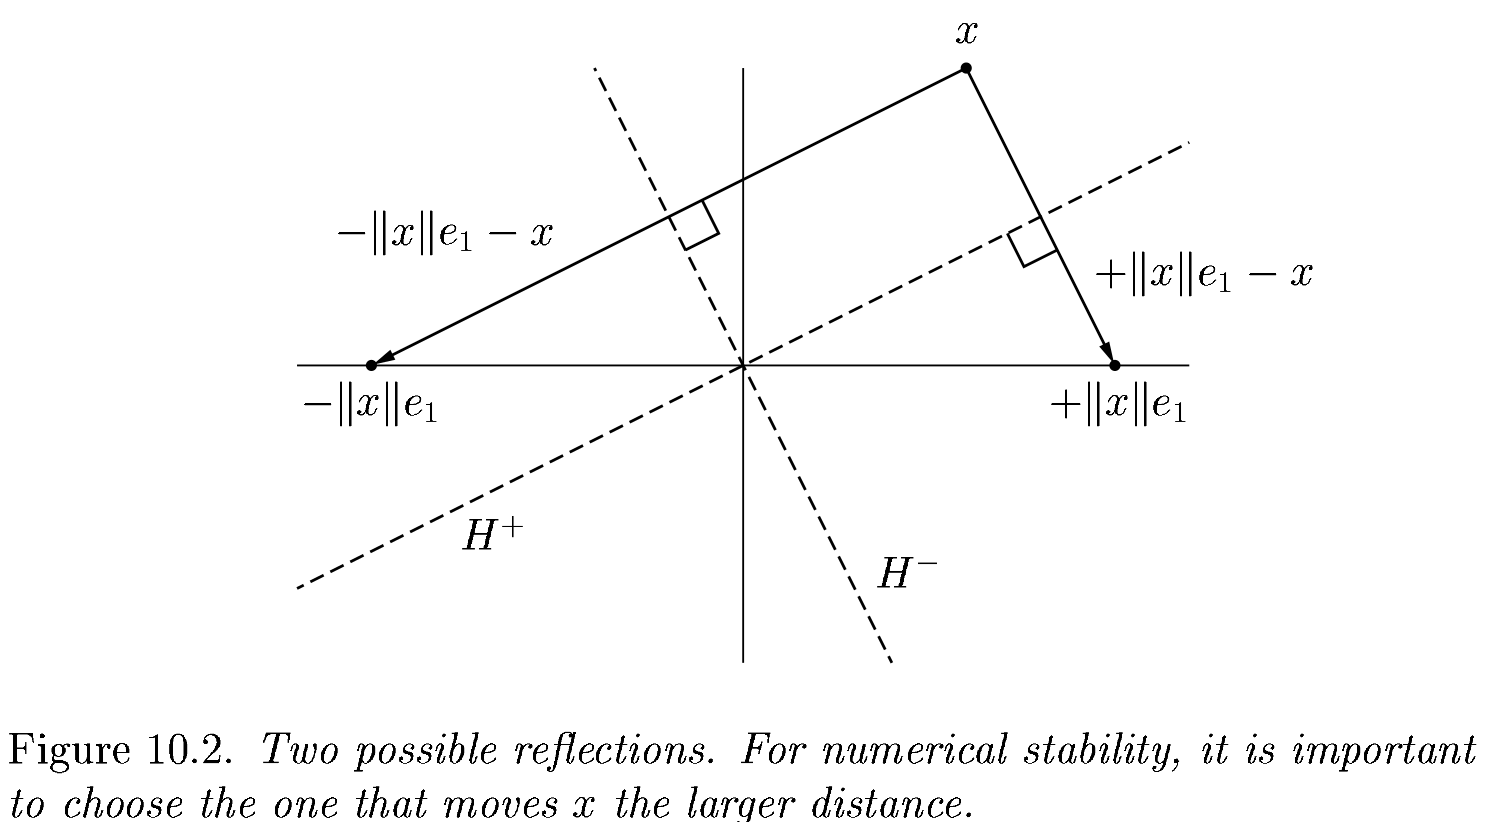

The reflection, as depicted above by Trefethen and Bau (1999) can be written as $F = I - 2 \frac{v v^T}{v^T v}$.
We want the reflector that moves $x$ the largest distance.

In [5]:
function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        # Build v for the current column
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # Here's the fix!
        v = normalize(v)
        # Build and apply F
        R[j:end, j:end] -= 2 * v * (v' * R[j:end,j:end])
        # Keep track of the reflectors
        push!(V, v)
    end
    V, R
end

qr_householder (generic function with 1 method)

Remember these helpers to convert $V$ to $Q$

In [6]:
# Here's a function to apply the reflectors V to a vector x
function reflectors_mult(V, x)
    y = copy(x)
    for v in reverse(V)
        n = length(v) - 1
        # This is applying F as we did to form R
        y[end-n:end] -= 2 * v * (v' * y[end-n:end])
    end
    y
end

# Create a dense matrix Q from reflectors V
function reflectors_to_dense(V)
    m = length(V[1])
    Q = diagm(ones(m))
    # Apply the reflectors to the identity matrix to build Q
    for j in 1:m
        Q[:, j] = reflectors_mult(V, Q[:,j])
    end
    Q
end

reflectors_to_dense (generic function with 1 method)

In [7]:
# Let's try it out
A = [2 -1; -1 2] * 1e-10

V, R = qr_householder(A)
tau = [2*v[1]^2 for v in V]
@show tau
V1 = [v ./ v[1] for v in V]
@show V1
println("R =")
display(R)

tau = [1.894427190999916, 2.0]
V1 = [[1.0, -0.2360679774997897], [1.0]]
R =


2×2 Matrix{Float64}:
 -2.23607e-10   1.78885e-10
  0.0          -1.34164e-10

## Householder is backward stable

We have finally fixed our loss of orthogonality problem!

In [8]:
# Let's try an example with Vandermonde
m = 40
x = LinRange(-1, 1, m)
A = vander(x, m)

V, R = qr_householder(A)
Q = reflectors_to_dense(V)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 5.932687575393109e-15
norm(Q * R - A) = 6.6179593854314975e-15


norm(v) = 1.4245900685395503


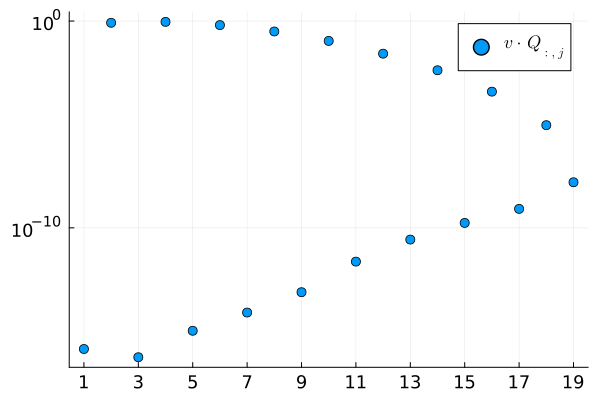

In [9]:
a = 20
x = LinRange(-1, 1, a)
A = vander(x)
Q, _ = gram_schmidt_classical(A)

v = A[:, end]
@show norm(v)
# Note, if v is actually orthogonal, these should be 0
scatter(abs.(Q[:, 1:end-1]' * v), yscale=:log10, xticks=range(1, a-1; step=2), label="\$v \\cdot Q_{:, j}\$")

norm(v) = 1.4245900685395503


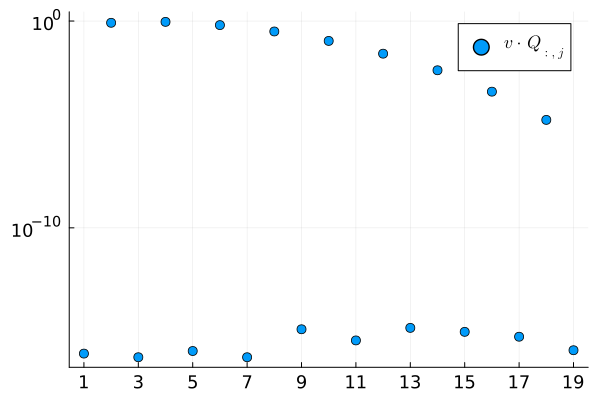

In [10]:
V, R = qr_householder(A)
Q = reflectors_to_dense(V)

v = A[:, end]
@show norm(v)
# Note, if v is actually orthogonal, these should be 0
scatter(abs.(Q[:, 1:end-1]' * v), yscale=:log10, xticks=range(1, a-1; step=2), label="\$v \\cdot Q_{:, j}\$")

## Composition of reflectors

$$ \begin{align}
(I - 2 v v^T) (I - 2 w w^T) &= I - 2 v v^T - 2 w w^T + 4 v (v^T w) w^T \\
&= I - \Bigg[v \Bigg| w \Bigg] \begin{bmatrix} 2 & -4 v^T w \\ 0 & 2 \end{bmatrix} \begin{bmatrix} v^T \\ w^T \end{bmatrix}
\end{align} $$

This turns applying reflectors from a sequence of vector operations to a sequence of (smallish) matrix operations.
It's the key to high performance and the native format (`QRCompactWY`) returned by Julia's `qr()`.

In [11]:
Q, R = qr(A)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}
Q factor: 20×20 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}
R factor:
20×20 Matrix{Float64}:
 -4.47214  0.0      -1.64763       0.0          …  -0.514468      2.22045e-16
  0.0      2.71448   1.11022e-16   1.79412         -2.22045e-16   0.823354
  0.0      0.0      -1.46813      -4.16334e-17     -0.944961     -1.68268e-16
  0.0      0.0       0.0          -0.774796        -7.26415e-17  -0.913056
  0.0      0.0       0.0           0.0              0.797217     -2.39731e-16
  0.0      0.0       0.0           0.0          …  -1.30513e-16   0.637796
  0.0      0.0       0.0           0.0             -0.455484     -5.47058e-16
  0.0      0.0       0.0           0.0              3.85024e-17  -0.313652
  0.0      0.0       0.0           0.0             -0.183132      1.28256e-15
  0.0      0.0       0.0           0.0             -2.51101e-16   0.109523
  0.0      0.0       0.0           0.0         

## Nonsquare matrices

$QR$ factorization also works for very nonsquare matrices.

In [12]:
# Much, much 'longer' than 'wide'
A = rand(1000000, 5)
Q, R = qr(A)
@show size(Q)
@show norm(Q*R - A)
R

size(Q) = (1000000, 1000000)
norm(Q * R - A) = 3.538426971490534e-12


5×5 Matrix{Float64}:
 -577.089  -432.471  -432.415  -433.388  -432.676
    0.0    -381.619  -162.868  -163.531  -163.242
    0.0       0.0     345.058   103.666   103.216
    0.0       0.0       0.0     329.259    76.1959
    0.0       0.0       0.0       0.0    -320.434

This is a "full" (or "complete") $QR$ factorization, in contrast to the reduced $QR$ factorization in which $Q$ has the same shape as $A$.

How much memory does $Q$ use?

You can compare with [`numpy.linalg.qr`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html)

* Need to decide up-front weather you want full or reduced $QR$

* Full $QR$ is expensive to represent

## Cholesky $QR$

The [**Cholesky decomposition**](https://en.wikipedia.org/wiki/Cholesky_decomposition) takes a [**Hermitian**](https://en.wikipedia.org/wiki/Hermitian_matrix), [**positive-definite**](https://en.wikipedia.org/wiki/Positive-definite_matrix) matrix and creates the lower triangular matrix $L$ such that $A = L L^T$ (more formally $A = L L^*$ where $L^*$ is the conjugate transpose, but we will stick to the real case here).

Consider the product $A^T A$.
Using the $QR$ factorization, we have

$$ A^T A = \left( Q R \right)^T Q R = R^T R $$

so we should be able to use $A^T A = L L^T = R^T R$ to find $R$ and then use $R$ to compute $Q$ as $Q = A L^{-T}$.

In [13]:
function qr_chol(A)
    R = cholesky(A' * A).U
    Q = A / R
    Q, R
end

A = rand(10, 4)
Q, R = qr_chol(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 1.3680071283797385e-15
norm(Q * R - A) = 2.699098171834165e-16


In [14]:
# But let's pick on Vandermonde again
x = LinRange(-1, 1, 15)
A = vander(x)
Q, R = qr_chol(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 3.960393895764547e-5
norm(Q * R - A) = 5.044150263130546e-16


We again see our loss of orthogonality.

## Repairing Cholesky $QR$

Note that the product of two triangular matrices is triangular.

In [15]:
R = triu(rand(5,5))
R * R

5×5 Matrix{Float64}:
 0.622166  0.21456    0.613734  0.597838   0.964626
 0.0       0.0185025  0.343078  0.0464937  0.238227
 0.0       0.0        0.487927  0.109346   0.147878
 0.0       0.0        0.0       0.376023   0.0595793
 0.0       0.0        0.0       0.0        0.0054071

Let's apply this Cholesky process twice and multiply our two $R$ matrices together.

In [16]:
function qr_chol2(A)
    Q, R = qr_chol(A)  # QR factorization
    Q, R1 = qr_chol(Q) # And again
    Q, R1 * R
end

x = LinRange(-1, 1, 15)
A = vander(x)
Q, R = qr_chol2(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 1.2262696169886244e-15
norm(Q * R - A) = 9.209900230881433e-16


## Profiling investigation

How fast are these methods?

In [17]:
m, n = 5000, 2000
A = randn(m, n)

@time qr(A);

  0.243139 seconds (9 allocations: 77.396 MiB, 1.57% gc time)


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


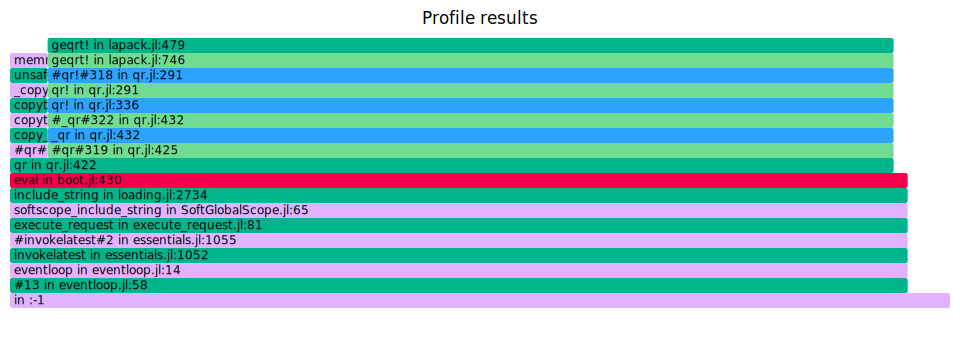

In [18]:
using Pkg
pkg"add ProfileSVG"
using ProfileSVG

@profview qr(A) # Note that memory actions are expensive!

## Profiling exploration

Compare the profile for our different implementations of $QR$ we have seen in class.
What stands out as expensive?

(Note, these commands are commented out as they take a while to run.)

In [19]:
# We can adjust profiling settings
using Profile

Profile.init() # returns the current settings
Profile.init(n = 10^5, delay = 0.001)

In [20]:
# Let's use a smaller matrix
m, n = 5000, 200
A = randn(m, n);

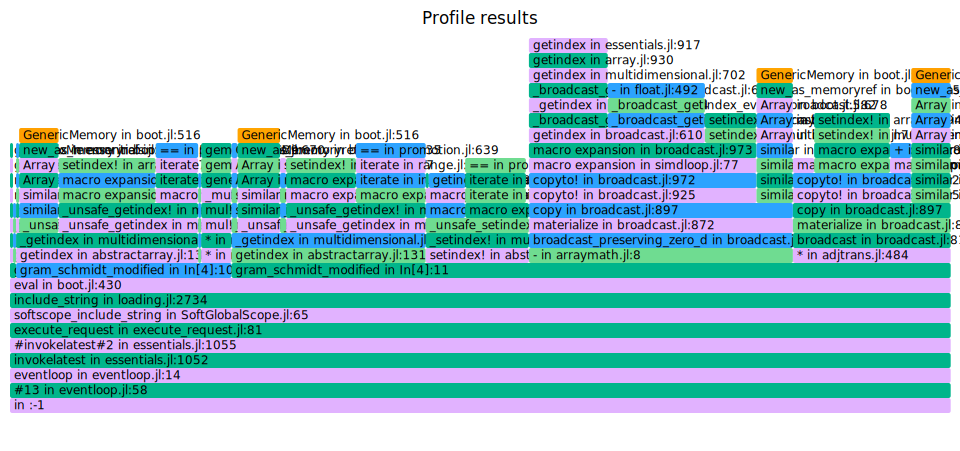

In [21]:
gram_schmidt_modified(A) # Run once to precompile
@profview gram_schmidt_modified(A)

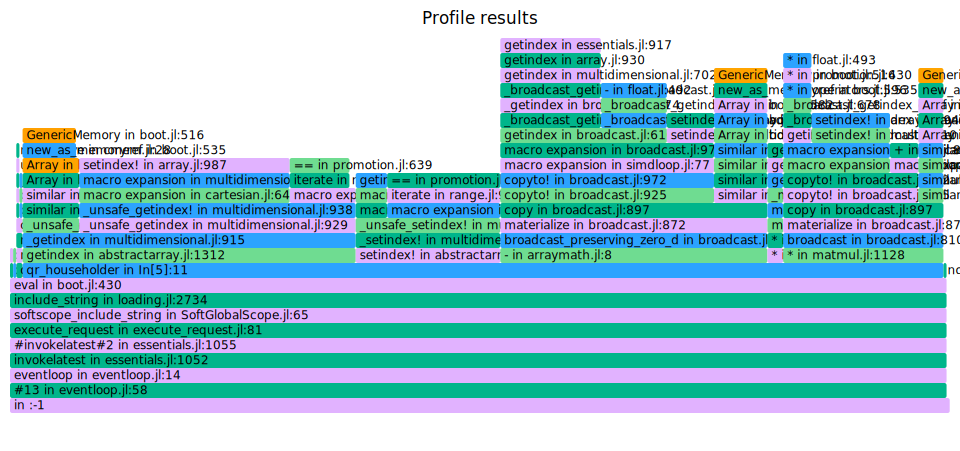

In [22]:
qr_householder(A)
@profview qr_householder(A)

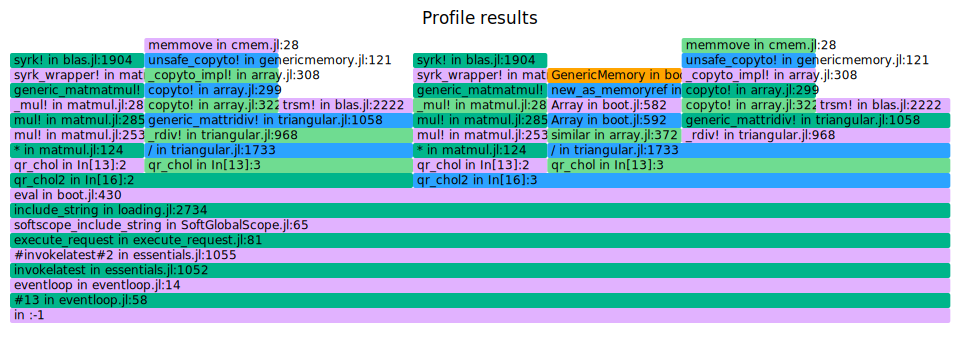

In [23]:
qr_chol2(A)
@profview qr_chol2(A)